Thinkful Bootcamp Course

Author: Ian Heaton

Email: iheaton@gmail.com

Mentor: Nemanja Radojkovic

Date: 2017/04/27


In [1]:
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.feature_selection import VarianceThreshold
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

%matplotlib inline

sb.set_style('darkgrid')
my_dpi = 76

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Prediction of Airline Delays with SVR


## Question:

Can domestic flight data from the U.S. Department of Transportation be used to accurately predict how late flights will be? 

### Data:

Data comes from the Kaggle web site, ‘Airlines Delay’  [1].   


### Context:

The U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics (BTS) tracks the on-time performance of domestic flights operated by large air carriers. Summary information on the number of on-time, delayed, canceled and diverted flights appears in DOT's monthly Air Travel Consumer Report, published about 30 days after the month's end, as well as in summary tables posted on this website. BTS began collecting details on the causes of flight delays in June 2003. 

### Content:
      
+ Year: 1987-2008
+ Month: 	            1-12
+ DayofMonth: 	        1-31
+ DayOfWeek: 	        1 (Monday) - 7 (Sunday)
+ DepTime: 	        actual departure time (local, hhmm)
+ CRSDepTime: 	        scheduled departure time (local, hhmm)
+ ArrTime: 	        actual arrival time (local, hhmm)
+ CRSArrTime: 	        scheduled arrival time (local, hhmm)
+ UniqueCarrier: 	    unique carrier code
+ FlightNum: 	        flight number
+ TailNum: 	        plane tail number
+ ActualElapsedTime: 	in minutes
+ CRSElapsedTime: 	in minutes
+ AirTime: 	in minutes
+ ArrDelay: 	arrival delay, in minutes
+ DepDelay: 	departure delay, in minutes
+ Origin: 	origin IATA airport code
+ Dest: 	destination IATA airport code
+ Distance: 	in miles
+ TaxiIn: 	taxi in time, in minutes
+ TaxiOut: 	taxi out time in minutes
+ Cancelled: 	was the flight cancelled?
+ CancellationCode: 	reason for cancellation (A = carrier, B = weather, C = NAS, D = security)
+ Diverted: 	1 = yes, 0 = no
+ CarrierDelay: 	in minutes
+ WeatherDelay: 	in minutes
+ NASDelay: 	in minutes
+ SecurityDelay: 	in minutes
+ LateAircraftDelay: 	in minutes


In [2]:
# Read CSV containing text data
data_file = '/media/ianh/space/ThinkfulData/AirlinesDelay/DelayedFlights.csv'
flights = pd.read_csv(data_file)
print("\nObservations : %d\n" % (flights.shape[0]))
print("\nFeatures : %d\n" % (flights.shape[1]))


Observations : 1936758


Features : 30



## Preprocessing and exploratory data analysis

In [3]:
# Check for missing data
print("%s\n" % (flights.isnull().sum()))

# Lets ensure that all columns are of the expected type object and int (or float)
print("\n%s\n" % (flights.dtypes))

Unnamed: 0                0
Year                      0
Month                     0
DayofMonth                0
DayOfWeek                 0
DepTime                   0
CRSDepTime                0
ArrTime                7110
CRSArrTime                0
UniqueCarrier             0
FlightNum                 0
TailNum                   5
ActualElapsedTime      8387
CRSElapsedTime          198
AirTime                8387
ArrDelay               8387
DepDelay                  0
Origin                    0
Dest                      0
Distance                  0
TaxiIn                 7110
TaxiOut                 455
Cancelled                 0
CancellationCode          0
Diverted                  0
CarrierDelay         689270
WeatherDelay         689270
NASDelay             689270
SecurityDelay        689270
LateAircraftDelay    689270
dtype: int64


Unnamed: 0             int64
Year                   int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64


There is a lot missing data for the observations. Let us drop these observations and check how many observations we have remaining. Northing looks out of place in regards to the data types for the columns. 

We are going to remove any feature that is not discrete or continuous. The specific delays time will also be removed as we are interested in predicting the arrival time delay. In addition, these delay appear to address delay times for departure which should summarized with the Departure Delay feature.

We will convert Origin, Destination and Carrier codes to integers.  It is important to maintain this information as some airports and carriers are perhaps  more prone to delays.  This is especially the case for busy airports such as O’Hare in the winter.   

In [4]:
# Drop all NaN values from the data
flights = flights.dropna()
print('After removing NaN values we have %d observations.\n' % (flights.shape[0]))

# Remove those Features that are alphanumeric and those that are duplicates with arrival and delay time
flights = flights.drop(['Unnamed: 0', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 
                        'CancellationCode', 'TailNum'], 1)

# Convert the carrier codes to integers values for analysis. 
# Airline information is important some are better than others
carrier_mapping = {'WN':1, 'XE':2, 'YV':3, 'OH':4, 'OO':5, 'UA':6, 'US':7, 'DL':8, 'EV':9, 'F9':11, 'FL':12,
                   'HA':13, 'MQ':14, 'NW':15, '9E':16, 'AA':17, 'AQ':18, 'AS':19, 'B6':20, 'CO':21}

flights.UniqueCarrier = flights.UniqueCarrier.map(carrier_mapping)


# Create mapping sequences for Origin and Destination airports
origin_data = list(flights.Origin.unique())
origin_mapping = dict( zip( origin_data, list(range(1, len(origin_data) + 1))))

dest_data = list(flights.Dest.unique())
dest_mapping = dict( zip( dest_data, list(range(1, len(dest_data) + 1))))

# Perform mapping
flights.Origin = flights.Origin.map(origin_mapping)
flights.Dest = flights.Dest.map(dest_mapping)
print('\nAfter removing and transforming some features we now have %d features' % (flights.shape[1]))
flights.head()

After removing NaN values we have 1247486 observations.


After removing and transforming some features we now have 22 features


,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
3,2008,1,3,4,1829.0,1755,1959.0,1925,1,3920,...,77.0,34.0,34.0,1,1,515,3.0,10.0,0,0
5,2008,1,3,4,1937.0,1830,2037.0,1940,1,509,...,230.0,57.0,67.0,1,2,1591,3.0,7.0,0,0
7,2008,1,3,4,1644.0,1510,1845.0,1725,1,1333,...,107.0,80.0,94.0,1,3,828,6.0,8.0,0,0
9,2008,1,3,4,1452.0,1425,1640.0,1625,1,675,...,213.0,15.0,27.0,1,4,1489,7.0,8.0,0,0
11,2008,1,3,4,1323.0,1255,1526.0,1510,1,4,...,110.0,16.0,28.0,1,5,838,4.0,9.0,0,0


### Feature Selection

There is at least 3 features remaining that have the same values for every observation remaining in the dataset after removing those rows with NaN.  We will perform variance thresholding to remove those features and any others that fall below the threshold.

In [5]:
# Now we will perform a rigorous approach of removing those features with zero variance.
selector = VarianceThreshold()
selector.fit(flights, flights.ArrDelay)
flights = flights.loc[:, selector.get_support()]
print('After removing those features that have zero variance, we have %d features' % (flights.shape[1]))
flights.head()

After removing those features that have zero variance, we have 19 features


,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut
3,1,3,4,1829.0,1755,1959.0,1925,1,3920,90.0,90.0,77.0,34.0,34.0,1,1,515,3.0,10.0
5,1,3,4,1937.0,1830,2037.0,1940,1,509,240.0,250.0,230.0,57.0,67.0,1,2,1591,3.0,7.0
7,1,3,4,1644.0,1510,1845.0,1725,1,1333,121.0,135.0,107.0,80.0,94.0,1,3,828,6.0,8.0
9,1,3,4,1452.0,1425,1640.0,1625,1,675,228.0,240.0,213.0,15.0,27.0,1,4,1489,7.0,8.0
11,1,3,4,1323.0,1255,1526.0,1510,1,4,123.0,135.0,110.0,16.0,28.0,1,5,838,4.0,9.0


Due to the memory and CPU constraints of the VM that this notebook was created and run on a Random Forest model is used as another Feature selection step. 

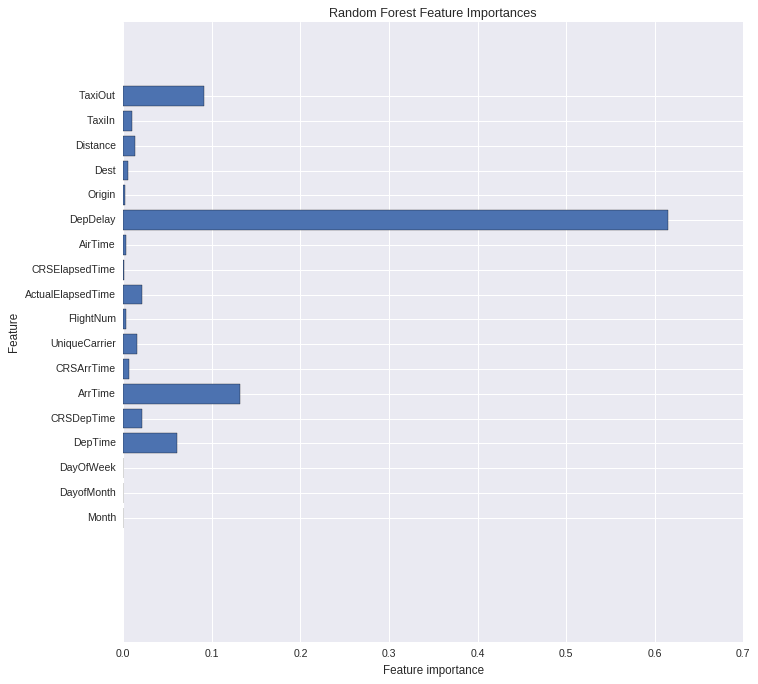

In [6]:
def plot_feature_importances(model, data, title):
    n_features = data.shape[1]
    plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), data.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.title(title)


X = flights.drop('ArrDelay', axis=1)
y = flights.ArrDelay

rfc = ensemble.RandomForestClassifier(
    n_estimators=16,
    max_depth=3
)


rfc.fit(X, y)
#print("\nAccuracy: {:.3f}".format(rfc.score(X, y)))
plot_feature_importances(rfc, X, "Random Forest Feature Importances")

In [7]:
# Timing context manager for statement invocations.
# Taken from Python Cookbook section 14.13
import time

from contextlib import contextmanager
@contextmanager
def timeblock(label):
    start = time.perf_counter()
    try:
        yield
    finally:
        end = time.perf_counter()
        print('{} : {:.4f}'.format(label, end - start))

In [ ]:
# Lets exclude those features that have been transformed from categorical data, 
# or that will have a uniform distribution. We know these will not have a normal distribution. 
# This will make possible to view the sub plots.
exclude = ['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest', 'FlightNum', 'UniqueCarrier',
          'Distance', 'AirTime', 'CRSElapsedTime']
data_for_plotting = flights.ix[:, flights.columns.difference(exclude)] 
__ = sb.pairplot(data_for_plotting)

Now we perform standardization on our data.  Using standardization, we center the feature columns at mean 0 with standard deviation 1 so that the feature columns take the form of a normal distribution, which makes it easier for SVR to  learn the weights. We use the Robust Scaler from sci kit learn which uses the  median and the interquartile range which will give better results when  outliers are present, which is the case this data set.
Outliers can often influence the sample mean / variance in a negative way. 

In [8]:
from sklearn.preprocessing import RobustScaler
from sklearn.cross_validation import train_test_split

exclude = ['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest', 'FlightNum', 'UniqueCarrier',
          'Distance', 'AirTime', 'CRSElapsedTime']

# Ok we drop all features that did not make the cut with the Random Forest selection
flights = flights.drop(exclude, axis=1)

# Having some trouble running all the test data through the fitting step
# My VM does not have the horse power (2 virtual processors and 8 GB of ram).
# This should create 20 different parts about 62,374 each
list_of_subframes = np.array_split(flights, 20)
sub_frame1 = list_of_subframes[0]

X = sub_frame1.drop('ArrDelay', axis=1)
y = sub_frame1.ArrDelay

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
rbstsc = RobustScaler()
X_train_std = rbstsc.fit_transform(X_train)
X_test_std = rbstsc.transform(X_test)

## Model Building

In [12]:
from sklearn.svm import SVR
from sklearn import metrics

svr = SVR(C=0.80, cache_size=5000)

with timeblock('Time Spent Fitting SVR'):
    svr.fit(X_train_std, y_train)
    y_ = svr.predict(X_train_std)


print("\nAccuracy on training set: {:.3f}".format(svr.score(X_train_std, y_train)))
print('\SVR RMSE of training set: %.3f\n' % (np.sqrt(metrics.mean_squared_error(y_train, y_))) )

print("\nAccuracy on test set: {:.3f}".format(svr.score(X_test_std, y_test)))
y_ = svr.predict(X_test_std)
print('\SVR RMSE of test set: %.3f' % (np.sqrt(metrics.mean_squared_error(y_test, y_))) )

Time Spent Fitting SVR : 131.9093

Accuracy on training set: 0.853
\SVR RMSE of training set: 21.788


Accuracy on test set: 0.853
\SVR RMSE of test set: 21.474


## Conclusions

Because of the limitations of the Ubuntu virtual machine that was used to run the Python notebooks only a small portion of the entire dataset was run through the SVR model.   SVM and SVR appear to be very memory intensive processes.  The dataset was reduced to 62, 374 observations and the fitting and prediction took a little over 2 minutes to complete!

The accuracy scores for the training and testing data sets appear to signal we have a balance between bias and variance, but again this dataset is  a subset of the larger dataset having over a million observations.  The RMSE is 21 minutes, not too good if a flight is considered late if the delay time is greater than 30 minutes. 


## References

1. https://www.kaggle.com/giovamata/airlinedelaycauses